<a href="https://colab.research.google.com/github/diroaryo/imkas-sentiment-analysis/blob/main/Sentiment_Analysis_Naive_Bayes_TF_IDF_IMkas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [3]:
# Cleaning Library
import numpy
import pandas as pd
import re
import ast

# Visualization Library
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Stemming Library
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Naive Bayes dan TF-ID Library dari Sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

#Evaluation Library dari Sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Read Data Ulasan dan Label IMkas

In [4]:
df_ulasan = pd.read_csv('/content/drive/MyDrive/Data PKL/dataset_ready_imkas.csv')
df_label = pd.read_csv('/content/drive/MyDrive/Data PKL/label_imkas_ready.csv')
df = df_ulasan.join(df_label)

df.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,Aplikasi yang sangat buruk dan membagongkan al...,0
1,Nisa Kurnia,5,2024-09-06 09:07:03,Lebih mudah,1
2,fregadayu Channel story,1,2024-09-05 15:33:03,Aplikasi sangat buruk upgrade susah transaksi ...,0
3,cecep hidayat,1,2024-09-05 13:57:11,"Transaksi sukses tapi saldo gak masuk,, respon...",0
4,ASP76,5,2024-09-05 11:34:12,Masukkan untuk perbaikan aplikasi di tanggapi ...,1


# Preprocessing

Check null dan duplicate

In [5]:
df.isnull().sum()

,0
userName,0
score,0
at,0
content,0
label,0


In [6]:
df.duplicated().sum()

0

Cleaning Text

In [7]:
df_clean = df.copy()
df_clean.shape

(339, 5)

In [8]:
def clean_review_text(text):
    # Menghapus URL
    text = re.sub(r'https?://\S+', '', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Menghapus emoji (karakter non-ASCII)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Menghapus tanda baca berlebihan
    text = re.sub(r'[^\w\s]', ' ', text)

    # Menghilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [9]:
df_clean['content'] = df_clean['content'].apply(clean_review_text)
df_clean.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,Aplikasi yang sangat buruk dan membagongkan al...,0
1,Nisa Kurnia,5,2024-09-06 09:07:03,Lebih mudah,1
2,fregadayu Channel story,1,2024-09-05 15:33:03,Aplikasi sangat buruk upgrade susah transaksi ...,0
3,cecep hidayat,1,2024-09-05 13:57:11,Transaksi sukses tapi saldo gak masuk respon C...,0
4,ASP76,5,2024-09-05 11:34:12,Masukkan untuk perbaikan aplikasi di tanggapi ...,1


Case folding

In [10]:
df_fold = df_clean.copy()
df_fold.shape

(339, 5)

In [11]:
df_fold['content'] = df_fold['content'].apply(lambda x: x.lower())
df_fold.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,aplikasi yang sangat buruk dan membagongkan al...,0
1,Nisa Kurnia,5,2024-09-06 09:07:03,lebih mudah,1
2,fregadayu Channel story,1,2024-09-05 15:33:03,aplikasi sangat buruk upgrade susah transaksi ...,0
3,cecep hidayat,1,2024-09-05 13:57:11,transaksi sukses tapi saldo gak masuk respon c...,0
4,ASP76,5,2024-09-05 11:34:12,masukkan untuk perbaikan aplikasi di tanggapi ...,1


Normalisasi

In [12]:
df_norm = df_fold.copy()
df_norm.shape

(339, 5)

In [13]:
normalization_dict = {
    "eror" : "error",
    "oke" : "ok",
    "okok" : "ok",
    "waww" : "wow",
    "moga" : "semoga",
    "kesinih" : "kesini",
    "gaj" : "tidak",
    "okelahh" : "ok",
    "jls" : "jelas",
    "komplen" : "komplain",
    "msh" : "masih",
    "duluh" : "dulu",
    "hadeuuuhhh" : "haduh",
    "blh" : "boleh",
    "uprgade" : "upgrade",
    "teruunggul" : "terunggul",
    "trus" : "terus",
    "jngn" : "jangan",
    "d" : "di",
    "beress" : "beres",
    "kerennn" : "keren",
    "kren" : "keren",
    "sat" : "bangsat",
    "tdk" : "tidak",
    "mantul" : "mantap",
    "jossss" : "keren",
    "anjeng" : "anjing",
    "jln" : "jalan",
    "respon" : "respond",
    "sy" : "saya",
    "trima" : "terima",
    "jd" : "jadi",
    "sok" : "so",
    "mantab" : "mantap",
    "okw" : "oke",
    "sdh" : "sudah",
    "hbgi" : "hubungi",
    "wa" : "whatsapp",
    "apk" : "aplikasi",
    "blm" : "belum",
    "tp" : "tapi",
    "okelahh" : "oke",
    "gntng" : "ganteng",
    "trimakasih" : "terima kasih",
    "yaa" : "ya",
    "jugaa" : "juga",
    "gk" : "tidak",
    "ehhh" : "eh",
    "jt" : "juta",
    "ribupun" : "ribu",
    "ga" : "tidak",
    "srh" : "suruh",
    "pake" : "pakai",
    "hadeuuuhhh" : "haduh",
    "yaaaaa" : "ya",
    "yg" : "yang",
    "klo" : "kalau",
    "apus" : "hapus",
    "anji" : "anjing",
    "tdk" : "tidak",
    "gimna" : "gimana",
    "cs" : "customer service",
    "gaada" : "tidak ada",
    "msi" : "masih",
    "ad" : "ada",
    "lainy" : "lainnya",
    "pakek" : "pakai",
    "aj" : "aja",
    "cma" : "cuma",
    "tf" : "transfer",
    "ko" : "kok",
    "pdhl" : "padahal",
    "knpa" : "kenapa",
    "bs" : "bisa",
    "bgt" : "banget",
    "gak" : "tidak",
    "jlk" : "jelek",
    "kgak" : "kagak",
    "rebu" : "ribu",
    "sekalin" : "sekali",
    "jls" : "jelas",
    "gabisa" : "tidak bisa",
    "ush" : "usah",
    "memhodohi" : "membodohi",
    "jangngan" : "jangan",
    "tipyan" : "tipuan",
    "byr" : "bayar",
    "dipke" : "dipake",
    "kl" : "kalau",
    "divoba" : "dicoba",
    "tpi" : "tapi",
    "d" : "di",
    "ni" : "ini",
    "upgradt" : "upgrade",
    "daptarnya" : "daftarnya",
    "ny" : "nya",
    "dg" : "dengan",
    "loch" : "loh",
    "reg" : "registrasi",
    "sja" : "saja",
    "lg" : "lagi",
    "cm" : "cuma",
    "kek" : "kayak",
    "kaga" : "tidak",
    "dipake" : "dipakai",
    "pedahal" : "padahal",
    "ama" : "sama",
    "duluh" : "dulu",
    "nggk" : "tidak",
    "jngn" : "jangan",
    "rb" : "ribu",
    "g" : "tidak",
    "lncar" : "lancar",
    "knp" : "kenapa",
    "membagongkan" : "membingungkan",
    "kdang" : "kadang",
    "skrng" : "sekarang",
    "dwolot" : "download",
    "doawnload" : "download",
    "kerennn" : "keren",
    "klayen" : "client",
    "tetep" : "tetap",
    "nyesel" : "nyesal",
    "kluar" : "keluar",
    "dikomplin" : "dikomplain",
    "wawww" : "wow",
    "taiii" : "tai",
    "asuuuuuu" : "asu",
    "trmksh" : "terima kasih",
    "karna" : "karena",
    "sumua" : "semua",
}



def normalize_text(str_text):
    for word, replacement in normalization_dict.items():
        str_text = re.sub(rf'\b{word}\b', replacement, str_text)
    return str_text

In [14]:
df_norm['content'] = df_norm['content'].apply(normalize_text)
df_norm.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,aplikasi yang sangat buruk dan membingungkan a...,0
1,Nisa Kurnia,5,2024-09-06 09:07:03,lebih mudah,1
2,fregadayu Channel story,1,2024-09-05 15:33:03,aplikasi sangat buruk upgrade susah transaksi ...,0
3,cecep hidayat,1,2024-09-05 13:57:11,transaksi sukses tapi saldo tidak masuk respon...,0
4,ASP76,5,2024-09-05 11:34:12,masukkan untuk perbaikan aplikasi di tanggapi ...,1


Tokenisasi

In [15]:
df_token = df_norm.copy()
df_token.shape

(339, 5)

In [16]:
df_token['content'] = df_token['content'].apply(lambda x: x.split())
df_token.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,"[aplikasi, yang, sangat, buruk, dan, membingun...",0
1,Nisa Kurnia,5,2024-09-06 09:07:03,"[lebih, mudah]",1
2,fregadayu Channel story,1,2024-09-05 15:33:03,"[aplikasi, sangat, buruk, upgrade, susah, tran...",0
3,cecep hidayat,1,2024-09-05 13:57:11,"[transaksi, sukses, tapi, saldo, tidak, masuk,...",0
4,ASP76,5,2024-09-05 11:34:12,"[masukkan, untuk, perbaikan, aplikasi, di, tan...",1


*Stopword Removal*

In [17]:
df_stop = df_token.copy()
df_stop.shape

(339, 5)

In [18]:
def import_words_from_file(file_path):
    words = []
    with open(file_path, 'r') as file:
        for line in file:
            word = line.strip()
            words.append(word)
    return words

def stopword_removal(tokens):
    new_list = []
    for word in tokens:
      if word not in stopwords:
        new_list.append(word)
    return new_list

In [19]:
file_path = "/content/drive/MyDrive/Data PKL/stopwords-id.txt"
stopwords = import_words_from_file(file_path)
print(stopwords)

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan'

In [20]:
df_stop['content'] = df_stop['content'].apply(lambda x: stopword_removal(x))
df_stop.head(5)

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,"[aplikasi, buruk, membingungkan, alias, anjing...",0
1,Nisa Kurnia,5,2024-09-06 09:07:03,[mudah],1
2,fregadayu Channel story,1,2024-09-05 15:33:03,"[aplikasi, buruk, upgrade, susah, transaksi, g...",0
3,cecep hidayat,1,2024-09-05 13:57:11,"[transaksi, sukses, saldo, masuk, respond, cus...",0
4,ASP76,5,2024-09-05 11:34:12,"[masukkan, perbaikan, aplikasi, tanggapi, cepa...",1


Stemming

In [21]:
df_stem = df_stop.copy()
df_stem.shape

(339, 5)

In [22]:
def stemming(text) :
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text:
      dt = stemmer.stem(w)
      do.append(dt)
    d_clean = []
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean

In [23]:
df_stem['content'] = df_stem['content'].apply(lambda x: stemming(x))
df_stem.head(5)

aplikasi buruk bingung alias anjing aplikasi tipu pantesan nilai ratingnya buruk download aplikasi rencana isi pulsa kuota saldo kurang pulsa masuk komplain pengaruh puas dasar tipu
mudah
aplikasi buruk upgrade susah transaksi gagal saldo kurang suruh nungguh xjam download aplikasi saldo lanjur ribu in customer service slow respond
transaksi sukses saldo masuk respond customer service lambat bot
masuk baik aplikasi tanggap cepat aplikasi jalan normal terimakasih
wow
ok
ok
kuota mahal
the best aplikasi
baik

aplikasi down lod
mntep
tolong baik masak upgrade premium aja susah gagal
bagus
ok
ribet guna
kesini bagus mohon maaf hapus appnya
senang insentif sales kunjung
bikin aplikasi mabok kali ya aja
imkas babi suruh update ngak ganti nomor hp kontoll kau imkas
instal aplikasi pinjol tipu data daftar hapus bahaya data salah aplikasi pinjol rugi depan nya tolong aplikasi pinjol tolong balik data hapus permanen data salah data penting
aplikasi top up aja kena biaya ngirim saldo rekening ken

,userName,score,at,content,label
0,Mukti Yan suhendra,1,2024-09-08 10:44:00,aplikasi buruk bingung alias anjing aplikasi t...,0
1,Nisa Kurnia,5,2024-09-06 09:07:03,mudah,1
2,fregadayu Channel story,1,2024-09-05 15:33:03,aplikasi buruk upgrade susah transaksi gagal s...,0
3,cecep hidayat,1,2024-09-05 13:57:11,transaksi sukses saldo masuk respond customer ...,0
4,ASP76,5,2024-09-05 11:34:12,masuk baik aplikasi tanggap cepat aplikasi jal...,1


In [24]:
df_stem.to_csv('/content/drive/MyDrive/Data PKL/preprocessed/df_stemmed.csv', index=False)

# Visualisasi

In [25]:
df_vis = pd.read_csv('/content/drive/MyDrive/Data PKL/preprocessed/df_stemmed.csv')
df_vis.shape

(339, 5)

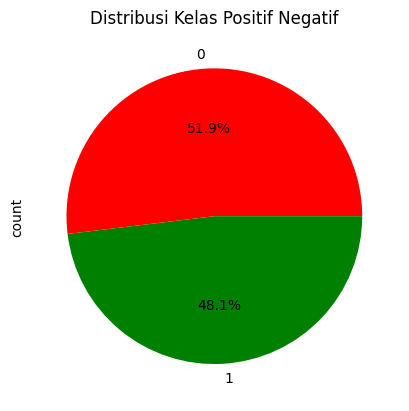

In [26]:
distribusi_kelas = df_vis['label'].value_counts()
distribusi_kelas.plot(kind='pie',autopct = "%1.1f%%" ,colors=['red', 'green'])
plt.title('Distribusi Kelas Positif Negatif')
plt.show()

<ipython-input-27-5e7fbaf47045>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  data_sentimen = pd.value_counts(df_vis['label'], sort = True)


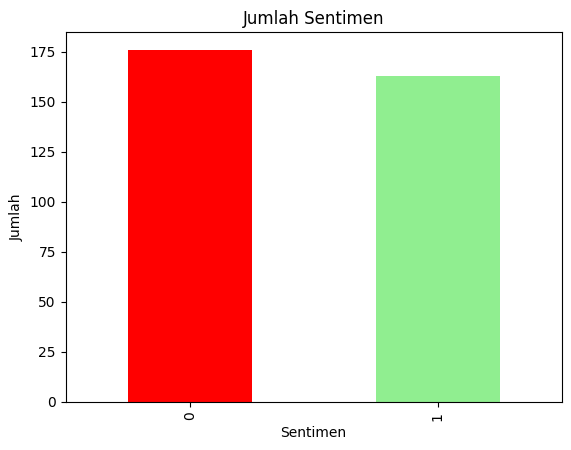

In [27]:
data_sentimen = pd.value_counts(df_vis['label'], sort = True)
data_sentimen.plot(kind = 'bar', color = ['red', "lightgreen"] )
plt.title("Jumlah Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [28]:
data_neg = df_vis[df_vis['label'] == 0]
data_pos = df_vis[df_vis['label'] == 1]

<ipython-input-29-b3a7a1445f85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['content'] = data_neg['content'].astype(str)


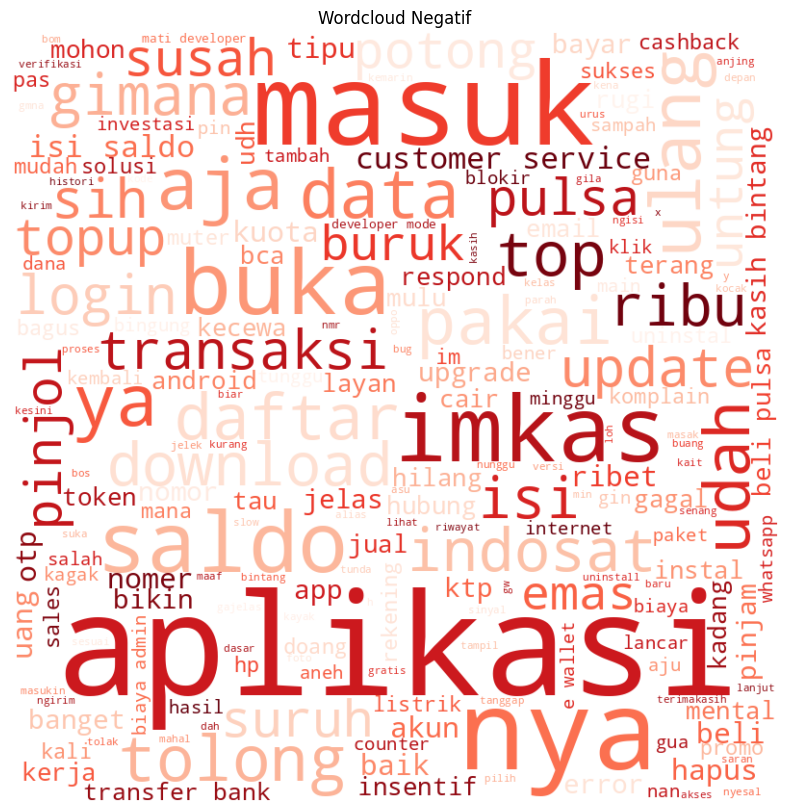

In [29]:
data_neg['content'] = data_neg['content'].astype(str)
all_text_neg = ' '.join(word for word in data_neg['content'])
wordcloud_neg = WordCloud(colormap = "Reds", mode = "RGBA" ,width=800, height=800, background_color='white').generate(all_text_neg)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Negatif")
plt.margins(x = 0, y = 0)
plt.show()

<ipython-input-30-30ec1923d17f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['content'] = data_pos['content'].astype(str)


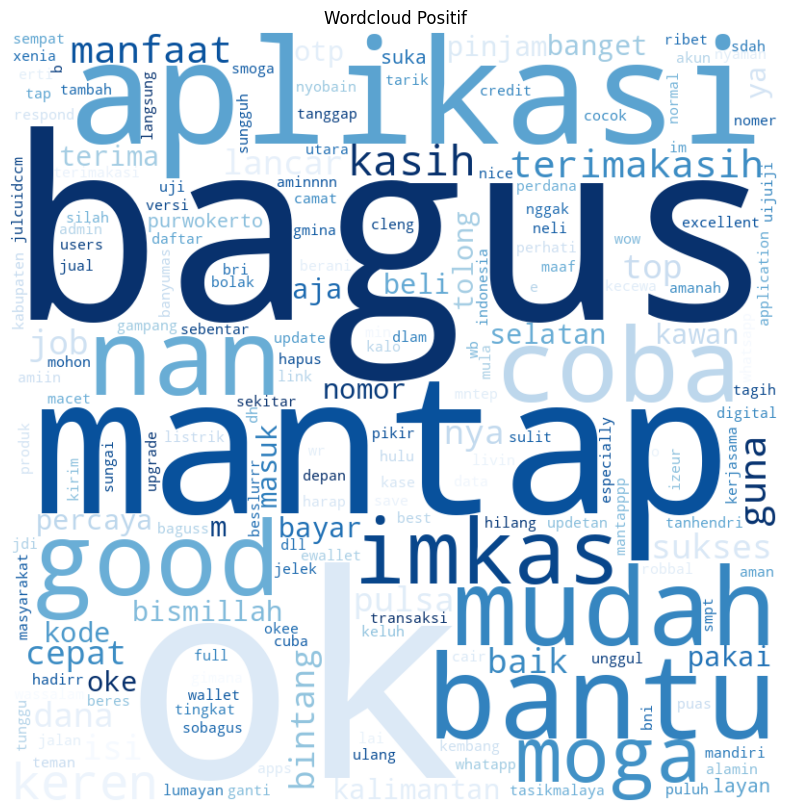

In [30]:
data_pos['content'] = data_pos['content'].astype(str)
all_text_pos = ' '.join(word for word in data_pos['content'])
wordcloud_pos = WordCloud(colormap = "Blues", mode = "RGBA" ,width=800, height=800, background_color='white').generate(all_text_pos)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Positif")
plt.margins(x = 0, y = 0)
plt.show()

# Analisis

*Feature Extraction*

In [31]:
df_extract = pd.read_csv('/content/drive/MyDrive/Data PKL/preprocessed/df_stemmed.csv')
df_extract.shape

(339, 5)

In [32]:
df_extract['content'] = df_extract['content'].astype(str)

vectorizer = TfidfVectorizer()

tfidf_features = vectorizer.fit_transform(df_extract['content'])

tfidf_vocab = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vocab)

tfidf_mean = tfidf_df.mean(axis=0)

tfidf_summary = pd.DataFrame({
    'Kata': tfidf_mean.index,
    'TF-IDF': tfidf_mean.values
})

tfidf_summary = tfidf_summary.sort_values(by='TF-IDF', ascending=False).reset_index(drop=True)

print(tfidf_summary)

         Kata    TF-IDF
0          ok  0.072280
1       bagus  0.055202
2    aplikasi  0.051965
3      mantap  0.045307
4         nan  0.041298
..        ...       ...
712     dekat  0.000398
713     sesui  0.000398
714      mkas  0.000398
715      sich  0.000398
716     berat  0.000398

[717 rows x 2 columns]


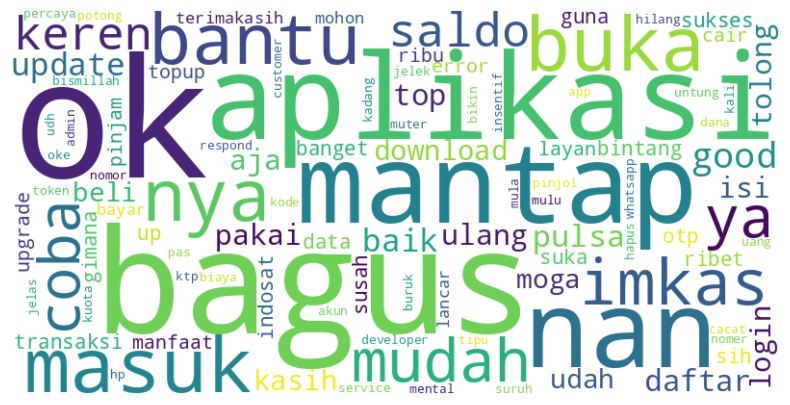

In [33]:
wordcloud_data = dict(zip(tfidf_summary['Kata'], tfidf_summary['TF-IDF']))

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white')

wordcloud.generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Classification & Evaluation

In [34]:
fold_wise_results = []

def custom_scoring(model, x, y):
    y_pred = model.predict(x)
    cm = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    fold_wise_results.append(cm)
    return accuracy

In [35]:
model = MultinomialNB()

tfidf_features_dense = tfidf_features.toarray()
tfidf_features_dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
param_grid = {
    'alpha': numpy.linspace(0.1, 1.0, 10)  # Mencari nilai alpha antara 0.1 hingga 1.0
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(tfidf_features_dense, df_extract['label'])

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [37]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

MultinomialNB(alpha=0.9)
{'alpha': 0.9}
0.8672080772607551


In [38]:
model2 = MultinomialNB(alpha=grid_search.best_params_['alpha'])

In [39]:
scores = cross_val_score(model2, tfidf_features_dense, df_extract['label'], cv=5, scoring=custom_scoring)
print(scores)

[0.85294118 0.88235294 0.86764706 0.88235294 0.85074627]


In [41]:
results = []

In [42]:
for i in range(5):
  cm = fold_wise_results[i]

  TP = cm[1][1]
  TN = cm[0][1]
  FP = cm[0][0]
  FN = cm[1][0]

  accuracy = scores[i]
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * (precision * recall) / (precision + recall)

  results.append({
        'Fold': i + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    })


  print(f"Fold {i + 1}:")
  print(f"Confusion Matrix:\n{cm}")
  print(f"True Positive: {TP}")
  print(f"True Negative: {TN}")
  print(f"False Positive: {FP}")
  print(f"False Negative: {FN}")
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")
  print('-' * 50)

Fold 1:
Confusion Matrix:
[[31  5]
 [ 5 27]]
True Positive: 27
True Negative: 5
False Positive: 31
False Negative: 5
Accuracy: 0.8529411764705882
Precision: 0.46551724137931033
Recall: 0.84375
F1 Score: 0.6
--------------------------------------------------
Fold 2:
Confusion Matrix:
[[31  4]
 [ 4 29]]
True Positive: 29
True Negative: 4
False Positive: 31
False Negative: 4
Accuracy: 0.8823529411764706
Precision: 0.48333333333333334
Recall: 0.8787878787878788
F1 Score: 0.6236559139784946
--------------------------------------------------
Fold 3:
Confusion Matrix:
[[31  4]
 [ 5 28]]
True Positive: 28
True Negative: 4
False Positive: 31
False Negative: 5
Accuracy: 0.8676470588235294
Precision: 0.4745762711864407
Recall: 0.8484848484848485
F1 Score: 0.6086956521739131
--------------------------------------------------
Fold 4:
Confusion Matrix:
[[31  4]
 [ 4 29]]
True Positive: 29
True Negative: 4
False Positive: 31
False Negative: 4
Accuracy: 0.8823529411764706
Precision: 0.4833333333333333

In [43]:
# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Tampilkan DataFrame
print(results_df)

   Fold  Accuracy  Precision    Recall  F1 Score    Confusion Matrix
0     1  0.852941   0.465517  0.843750  0.600000  [[31, 5], [5, 27]]
1     2  0.882353   0.483333  0.878788  0.623656  [[31, 4], [4, 29]]
2     3  0.867647   0.474576  0.848485  0.608696  [[31, 4], [5, 28]]
3     4  0.882353   0.483333  0.878788  0.623656  [[31, 4], [4, 29]]
4     5  0.850746   0.473684  0.843750  0.606742  [[30, 5], [5, 27]]


In [45]:
results_df.to_csv('/content/results_nb.csv', index=False)

<Figure size 1200x600 with 0 Axes>

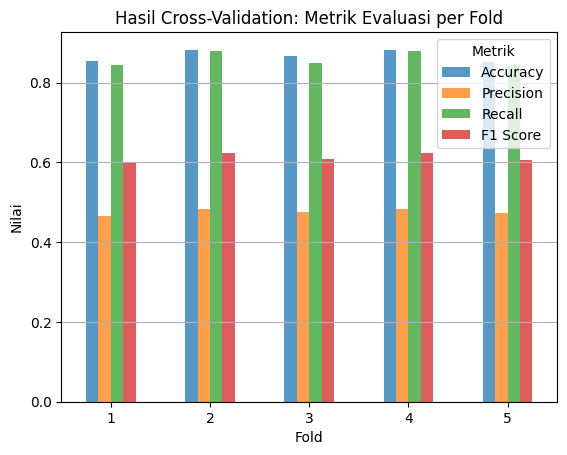

In [46]:
# Siapkan data untuk visualisasi
metrics_df = results_df[['Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].set_index('Fold')

# Plot metrik evaluasi
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', alpha=0.75)
plt.title('Hasil Cross-Validation: Metrik Evaluasi per Fold')
plt.xlabel('Fold')
plt.ylabel('Nilai')
plt.xticks(rotation=0)
plt.legend(title='Metrik')
plt.grid(axis='y')
plt.show()

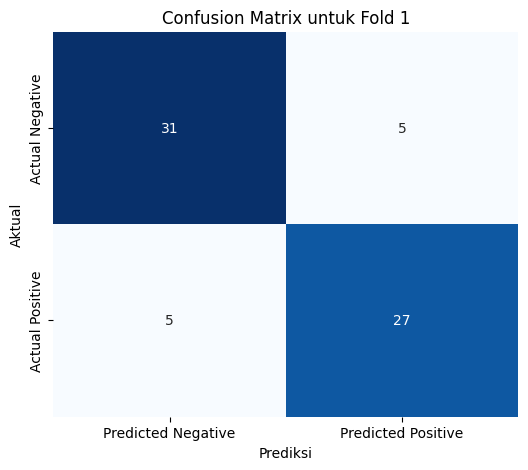

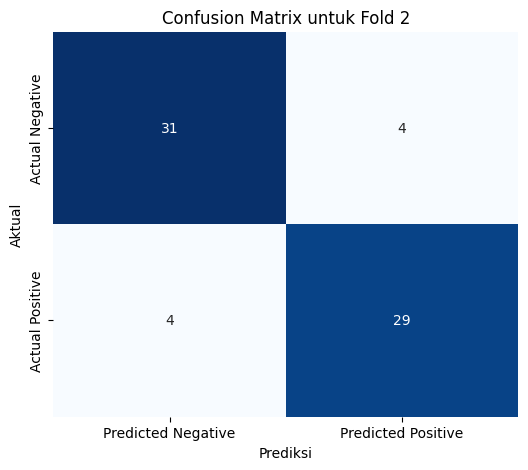

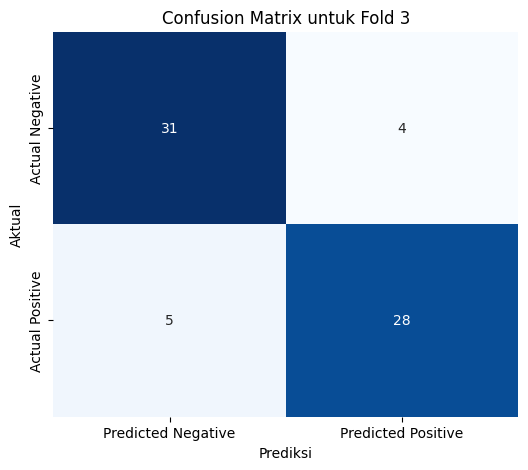

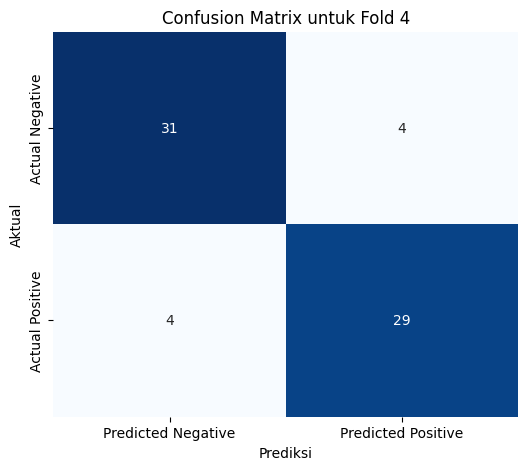

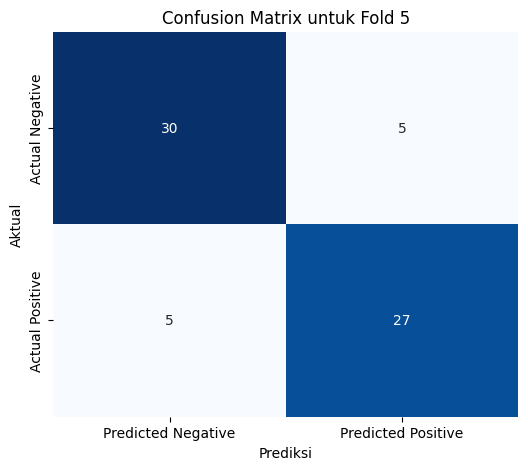

In [48]:
import seaborn as sns

# Buat heatmap untuk setiap confusion matrix
for i in range(5):
    cm = fold_wise_results[i]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix untuk Fold {i + 1}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()